In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import utils
import copy, time
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.family'] = 'STIXGeneral'  # Closely matches Computer Modern
plt.rcParams['mathtext.fontset'] = 'stix'    # Use STIX for math

## Initial code tests

In [ ]:
# Example TOAs in MJD (Modified Julian Date)
toas = jnp.linspace(58000.0, 61000.0, 1000) * 86400.

In [ ]:
# Instantiate the pulsar with those TOAs and sky position
psr = utils.Pulsar(name="J1234+5678", 
             ra_ring=jnp.radians(123.4567), dec=jnp.radians(56.7890), 
             toas=toas)

In [ ]:
cw_signal = utils.CW_Signal(psr=psr, tref=psr.toas[0], evolve=False)

pars = dict(
    cw_costheta=0.99,
    cw_phi=0.,
    cw_cosinc=0.99,
    cw_log10_Mc=9.5,
    cw_log10_fgw=-8.,
    cw_log10_dist=2.,
    cw_phase0=0.,
    cw_psi=0.,
)

# Compute the binary delays
delays = cw_signal.get_delay(pars=pars)

# Plot TOAs vs. delays
plt.figure(figsize=(8,4))
plt.plot((psr.toas-psr.toas[0])/365.25/86400., delays, marker=None, linestyle='-')
plt.xlabel("MJD TOA")
plt.ylabel("Binary Delay (s)")
plt.title(f"Binary Delays for Pulsar {psr.name}")
plt.grid(True)
plt.show()

In [ ]:
# get the list of your parameter‐names
param_keys = list(pars.keys())

# cast your integer param_values → float
param_vec = jnp.array(list(pars.values()))

# define a function from flat vec → delays
def delay_vec(vec):
    # rebuild the dict and compute delays
    p = dict(zip(param_keys, vec))
    return cw_signal.get_delay(pars=p)

# compute full Jacobian: shape (n_params, n_toas)
jac = jax.jacrev(delay_vec)(param_vec)

In [ ]:
test = jac.T @ jac

In [ ]:
rms = 1e-6
#deltaT = 14. * 86400. 
fisher = test / rms**2 #/ deltaT

In [ ]:
jnp.diag(jnp.linalg.pinv(fisher))**0.5

## PTA Fisher matrix tests for CWs

In [ ]:
# Draw npsr isotropic sky positions
npsrs = 20
key = jax.random.PRNGKey(42)
key_u, key_ra = jax.random.split(key)
u = jax.random.uniform(key_u, shape=(npsrs,), minval=-1.0, maxval=1.0)
dec = jnp.arcsin(u)
ra = jax.random.uniform(key_ra, shape=(npsrs,), minval=0.0, maxval=2 * jnp.pi)

# Define 100 TOAs over 10 years at 10 per year, with 100 ns errors
t0 = 58000.0 * 86400.0
t1 = t0 + 10.0 * 365.25 * 86400.0
toas_new = jnp.linspace(t0, t1, 100)
toaerrs = jnp.full_like(toas_new, 1e-6)

# Instantiate 100 pulsars
psrs = [
    utils.Pulsar(
        name=f"PSR{i:03d}",
        ra=ra[i],
        dec=dec[i],
        toas=toas_new,
        toaerrs=toaerrs
    )
    for i in range(npsrs)
]

In [ ]:
# Instantiate a CW_Signal for each pulsar in the psrs list
cw_signals = [
    utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
    for p in psrs
]

In [ ]:
pars = dict(
    cw_costheta=0.0,
    cw_phi=0.,
    cw_cosinc=0.99,
    cw_log10_Mc=9.5,
    cw_log10_fgw=-8.,
    cw_log10_dist=2.385,
    cw_phase0=0.,
    cw_psi=0.,
)
param_keys = list(pars.keys())
param_vec = jnp.array(list(pars.values()))

# compute the Fisher matrix for each CW_Signal / pulsar
def compute_fisher(cw_signal):
    # rebuild delays function
    def delay_vec(vec):
        p = dict(zip(param_keys, vec))
        return cw_signal.get_delay(pars=p)
    # Jacobian: shape (n_params, n_toas)
    jac = jax.jacrev(delay_vec)(param_vec)
    # “test” matrix and Fisher
    info_mat = jac.T @ (jac/cw_signal.psr.toaerrs[:,None]**2)
    return info_mat

# list of fisher matrices, one per pulsar
fishers = [compute_fisher(cw) for cw in cw_signals]
total_fisher = jnp.sum(jnp.stack(fishers), axis=0)

In [ ]:
def computer_snr2(cw_signal):
    # rebuild delays function
    sig = cw_signal.get_delay(pars=pars)
    snr2 = sig @ (sig/cw_signal.psr.toaerrs**2)
    return snr2

total_snr = jnp.sum(jnp.stack([computer_snr2(cw) for cw in cw_signals]), axis=0)**0.5
print("Total SNR: ", total_snr)

In [ ]:
jnp.diag(jnp.linalg.pinv(total_fisher))**0.5

In [ ]:
(180/jnp.pi)**2 * 2.0*jnp.pi/jnp.linalg.det(total_fisher[:2,:2])**0.5

In [ ]:
# Mollweide projection of pulsar sky locations and GW source
# wrap RA into [-π, +π] for plotting
ra_wrap = (ra + jnp.pi) % (2 * jnp.pi) - jnp.pi

# GW source sky coords from pars
gw_dec = jnp.arcsin(pars['cw_costheta'])
gw_ra  = (pars['cw_phi'] + jnp.pi) % (2 * jnp.pi) - jnp.pi

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='mollweide')
ax.scatter(ra_wrap, dec, s=15, color='C0', alpha=0.7, label='Pulsars')
ax.scatter(gw_ra,   gw_dec, s=150, color='C3', marker='*', label='GW Source')
ax.grid(True)
ax.set_xlabel('RA [rad]')
ax.set_ylabel('Dec [rad]')
ax.legend(loc='lower left')
plt.title('Mollweide Projection of Pulsar Sky & GW Origin')
plt.show()

## Binary and timing properties

In [2]:
pars = dict(
    cw_costheta=0.01,
    cw_phi=0.0,
    cw_cosinc=0.99,
    cw_log10_Mc=9.5,
    cw_log10_fgw=-8.0,
    cw_log10_dist=2.385,
    cw_phase0=0.0,
    cw_psi=0.0,
)

# Define 100 TOAs over 10 years at 10 per year, with 100 ns errors
t0 = 58000.0 * 86400.0
t1 = t0 + 10.0 * 365.25 * 86400.0
toas_new = jnp.linspace(t0, t1, 100)
toaerrs = jnp.full_like(toas_new, 1e-7)

## Exploring angular resolution by pulsar proximity

### Ring

In [80]:
psrs_ring = utils.pulsar_ring_generator(pars=pars, ang_radius=50.0, npsrs=3, toas=toas_new, toaerrs=toaerrs)

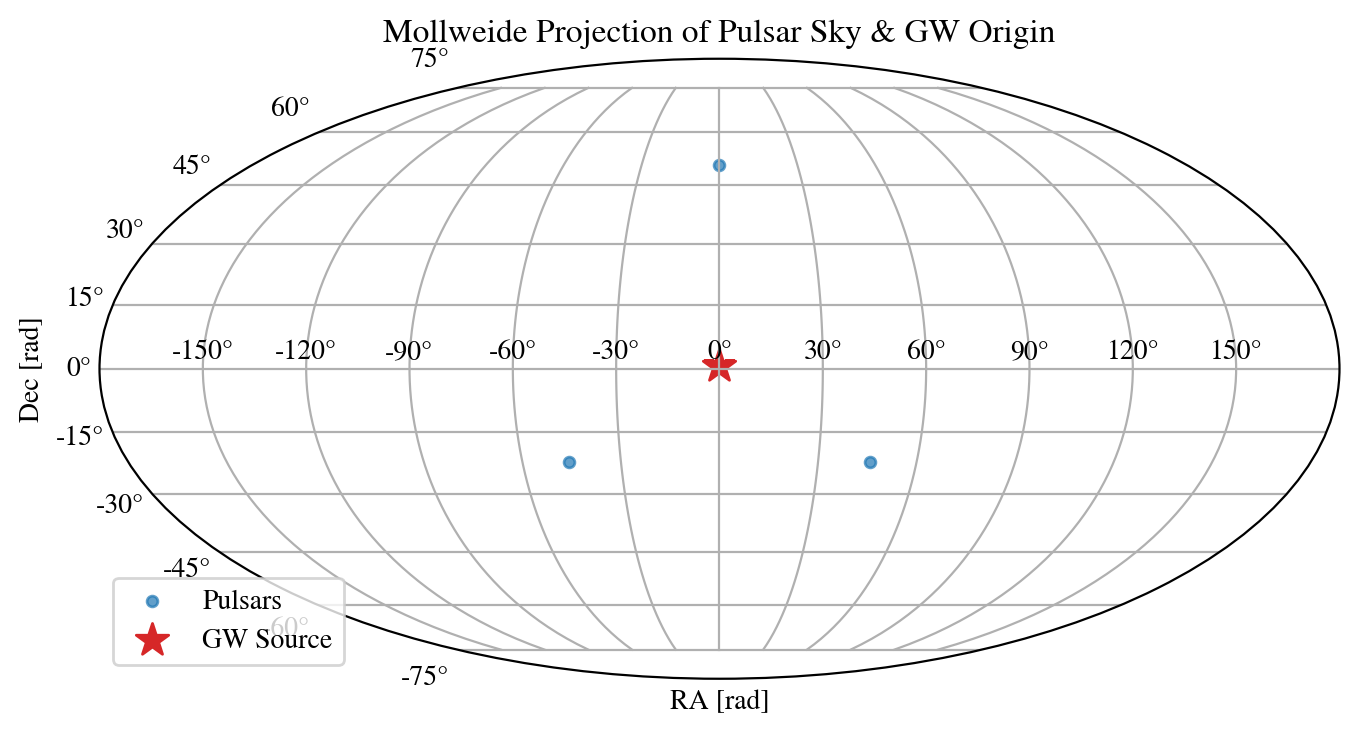

In [81]:
ra_ring = jnp.array([p.ra for p in psrs_ring])
dec_ring = jnp.array([p.dec for p in psrs_ring])
# Mollweide projection of pulsar sky locations and GW source
# wrap RA into [-π, +π] for plotting
ra_wrap = (ra_ring + jnp.pi) % (2 * jnp.pi) - jnp.pi

# GW source sky coords from pars
gw_dec = jnp.arcsin(pars['cw_costheta'])
gw_ra  = (pars['cw_phi'] + jnp.pi) % (2 * jnp.pi) - jnp.pi

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='mollweide')
ax.scatter(ra_wrap, dec_ring, s=15, color='C0', alpha=0.7, label='Pulsars')
ax.scatter(gw_ra,   gw_dec, s=150, color='C3', marker='*', label='GW Source')
ax.grid(True)
ax.set_xlabel('RA [rad]')
ax.set_ylabel('Dec [rad]')
ax.legend(loc='lower left')
plt.title('Mollweide Projection of Pulsar Sky & GW Origin')
plt.show()

In [7]:
# Instantiate a CW_Signal for each pulsar in the psrs list
cw_signals = [
    utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
    for p in psrs_ring
]

# deep-copy the dictionary so nested objects are also copied
pars_copy = copy.deepcopy(pars)
total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
pars_copy['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 10.)
# list of fisher matrices, one per pulsar
fishers = [utils.compute_fisher(cw,pars_copy) for cw in cw_signals]
total_fisher = jnp.sum(jnp.stack(fishers), axis=0)

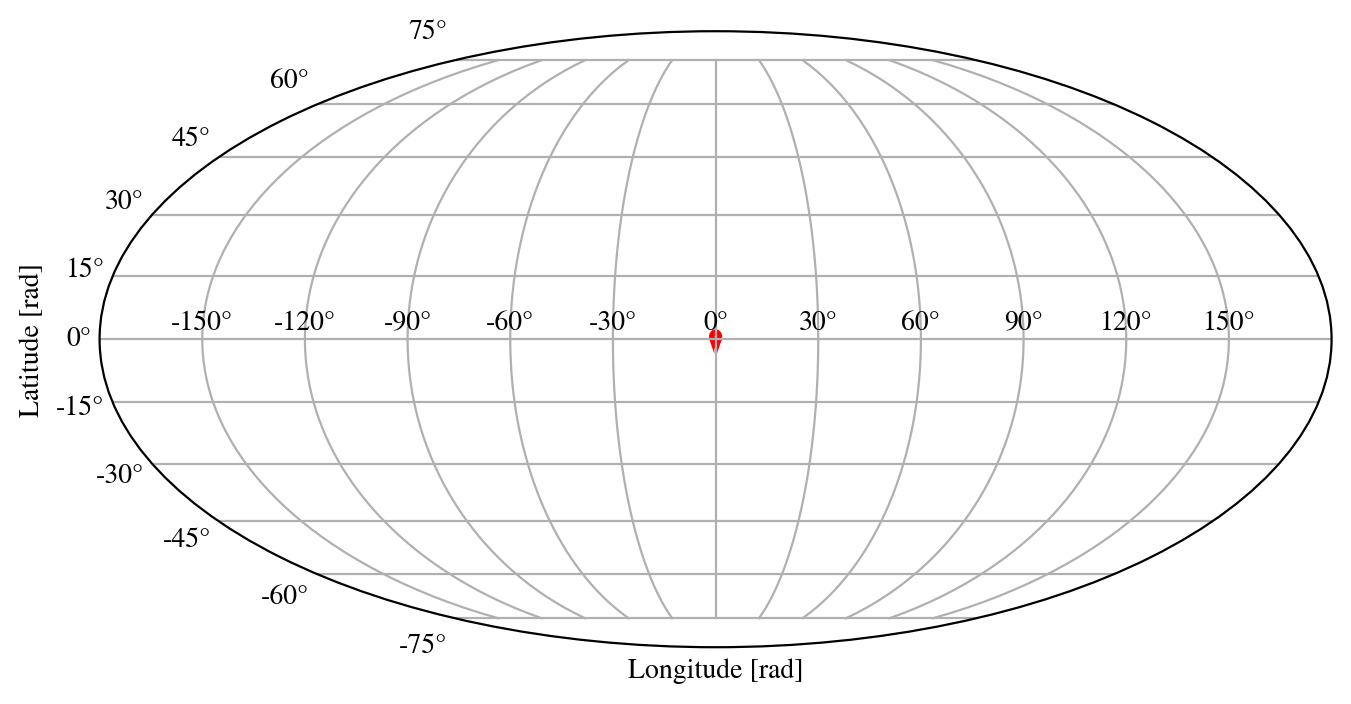

In [ ]:
# Center in degrees (lon, lat)
center_uphi = (pars['cw_costheta'], pars['cw_phi'])

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='mollweide')
utils.plot_fisher_ellipse_on_sky(total_fisher[:2,:2], center_uphi, ax=ax,
                                edgecolor='red', facecolor='none', lw=2)
ax.grid(True)
ax.set_xlabel('Longitude [rad]')
ax.set_ylabel('Latitude [rad]')
plt.show()

#### Fix SNR to 10. Number of pulsars = 20.

In [10]:
angles = jnp.linspace(1.,70.,40)
omega_sky = []
for ang in angles:
    psrs_ring = utils.pulsar_ring_generator(pars=pars, ang_radius=ang, npsrs=20, 
                                            toas=toas_new, toaerrs=toaerrs)
    # Instantiate a CW_Signal for each pulsar in the psrs list
    cw_signals = [
        utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
        for p in psrs_ring
                 ]
    
    # deep-copy the dictionary so nested objects are also copied
    pars_copy = copy.deepcopy(pars)
    total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    pars_copy['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 10.)
    # list of fisher matrices, one per pulsar
    fishers = [utils.compute_fisher(cw,pars_copy) for cw in cw_signals]
    total_fisher = jnp.sum(jnp.stack(fishers), axis=0)
    
    #modified_snr = jnp.sum(jnp.stack([computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    #print(total_snr, modified_snr)
    #omega_sky.append( (180/jnp.pi)**2 * 2.0*jnp.pi/jnp.linalg.det(total_fisher[:2,:2])**0.5 )

    fisher_inv = jnp.linalg.pinv(total_fisher)[:2,:2]
    omega_sky.append( (180/jnp.pi)**2 * 2.0*jnp.pi * jnp.linalg.det(fisher_inv)**0.5 )

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:48: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)


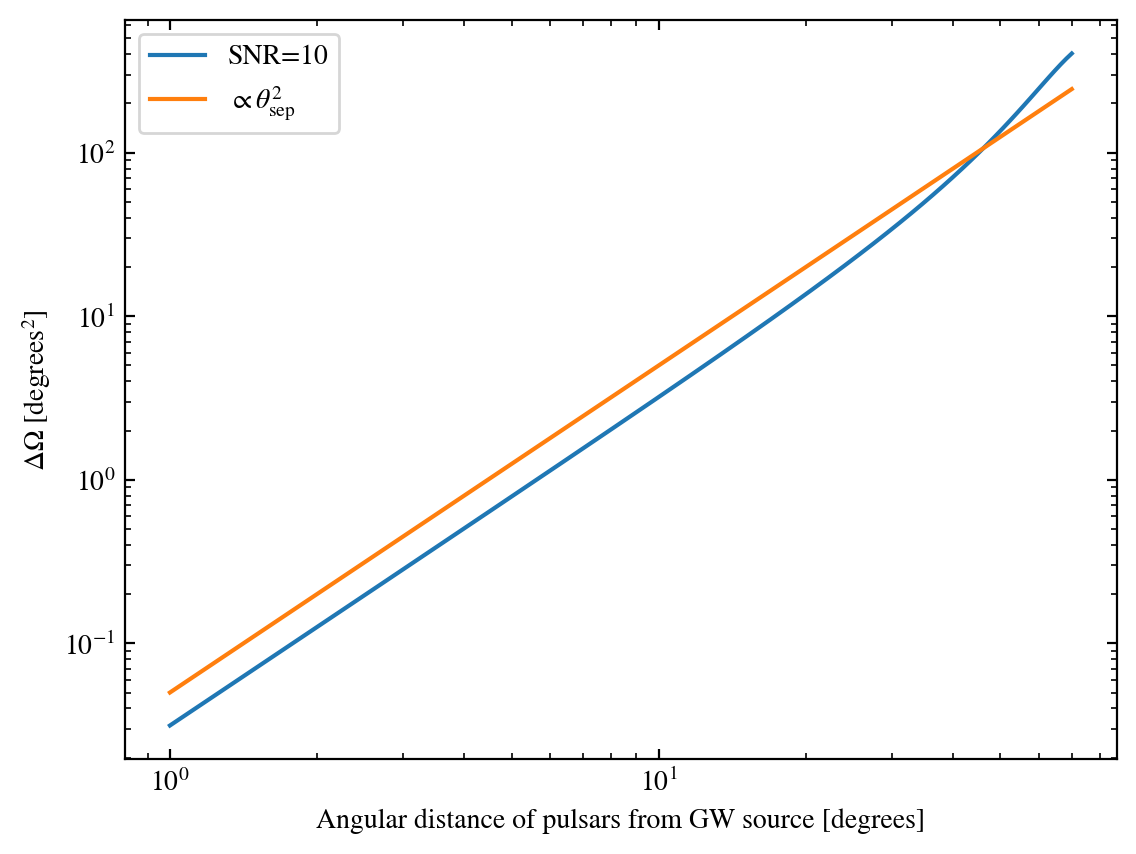

In [20]:
plt.plot(angles, jnp.array(omega_sky), label='SNR=10');
#plt.plot(angles, jnp.array(omega_sky_cosinc0), label='SNR=10');
#plt.plot(angles, omega_sky, label='SNR=10');
plt.plot(angles, 0.05*jnp.array(angles)**2.0, label='$\propto \\theta_\mathrm{sep}^2$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angular distance of pulsars from GW source [degrees]')
plt.ylabel('$\Delta\Omega$ [degrees$^2$]')
plt.minorticks_on()
plt.tick_params(which='both',tick2On=True,direction='in')
plt.legend()
plt.show()

#### Don't fix the SNR

In [33]:
angles = jnp.linspace(1.,70.,40)
omega_sky_vsnr = []
snrs = []

seed = int(time.time() * 1e6) % (2**31 - 1)
key = jax.random.PRNGKey(seed)

for ang in angles:
    key, subkey = jax.random.split(key)
    npsrs = int(jax.random.randint(subkey, (), 10, 51))
    print(npsrs)

    # deep-copy the dictionary so nested objects are also copied
    pars_copy = copy.deepcopy(pars)
    key, subkey2 = jax.random.split(key)
    key, subkey3 = jax.random.split(key)
    key, subkey4 = jax.random.split(key)
    key, subkey5 = jax.random.split(key)
    pars_copy['cw_log10_dist'] = jax.random.uniform(subkey2, minval=2.5, maxval=4.0)
    pars_copy['cw_cosinc'] = jax.random.uniform(subkey3, minval=-0.99, maxval=0.99)
    pars_copy['cw_psi'] = jax.random.uniform(subkey4, minval=0.01, maxval=jnp.pi-0.01)
    pars_copy['cw_phase0'] = jax.random.uniform(subkey5, minval=0.01, maxval=2.0*jnp.pi-0.01)

    psrs_ring = utils.pulsar_ring_generator(pars=pars_copy, ang_radius=ang, npsrs=npsrs, 
                                            toas=toas_new, toaerrs=toaerrs)
    # Instantiate a CW_Signal for each pulsar in the psrs list
    cw_signals = [
        utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
        for p in psrs_ring
                ]
    
    # deep-copy the dictionary so nested objects are also copied
    #pars_copy = copy.deepcopy(pars)
    total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy) 
                                   for cw in cw_signals]), axis=0)**0.5
    snrs.append(total_snr)
    #snrs.append([utils.computer_snr2(cw,pars_copy) for cw in cw_signals])

    #pars_copy['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 10.)
    # list of fisher matrices, one per pulsar
    fishers = [utils.compute_fisher(cw,pars_copy) for cw in cw_signals]
    total_fisher = jnp.sum(jnp.stack(fishers), axis=0)
    #modified_snr = jnp.sum(jnp.stack([computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    #print(total_snr, modified_snr)
    
    fisher_inv = jnp.linalg.pinv(total_fisher)[:2,:2]
    omega_sky_vsnr.append( (180/jnp.pi)**2 * 2.0*jnp.pi * jnp.linalg.det(fisher_inv)**0.5 )

39


/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:48: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)


37
14
48
12
47
21
38
14
24
30
41
36
19
25
40
49
29
41
13
19
30
30
24
39
18
34
12
21
36
23
48
35
15
44
43
40
26
41
15


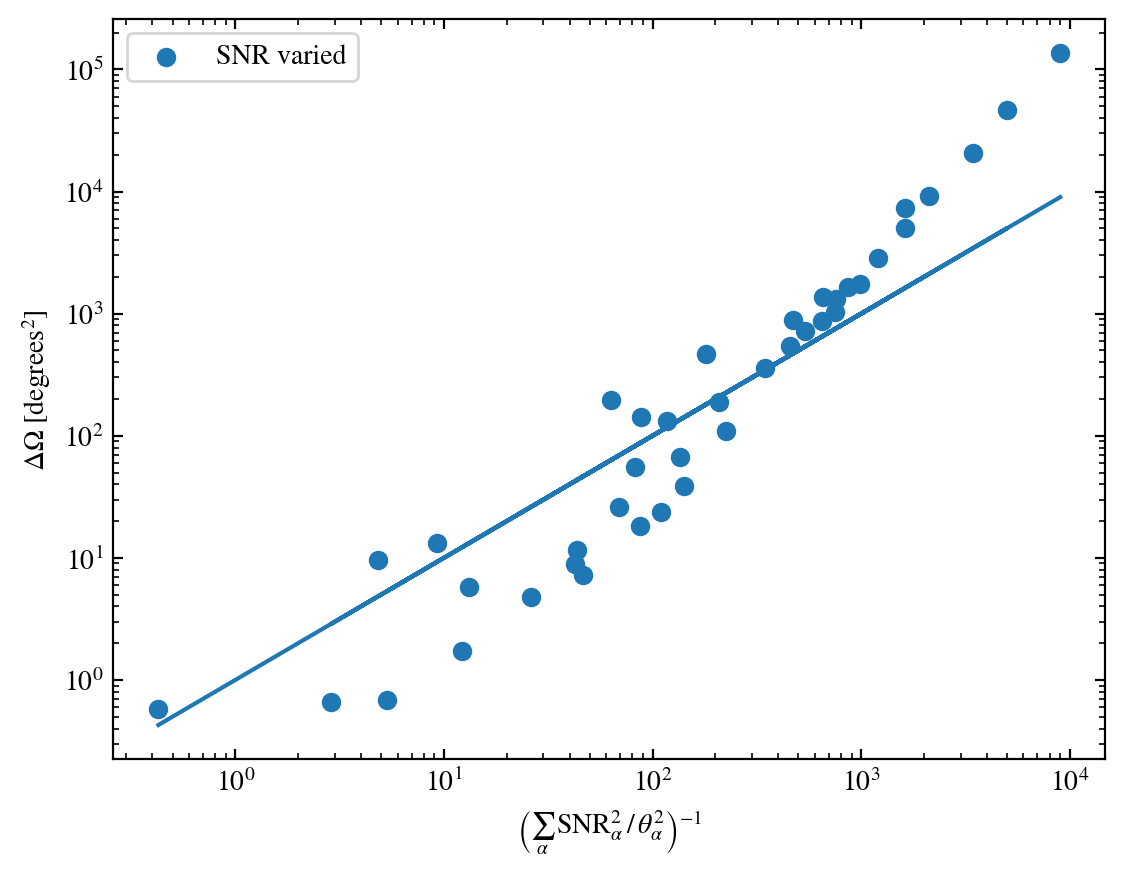

In [36]:
scaling = 1.0 / (jnp.array(snrs) / jnp.array(angles)**2.0)

plt.scatter(scaling, jnp.array(omega_sky_vsnr), label='SNR varied');
#plt.plot(angles, omega_sky, label='SNR=10');
plt.plot(scaling, scaling, label='' )#/ jnp.array(snrs)**2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\left(\\sum_\\alpha\, \mathrm{SNR}_\\alpha^2 \,/\, \\theta_\\alpha^2\\right)^{-1}$')
plt.ylabel('$\Delta\Omega$ [degrees$^2$]')
plt.minorticks_on()
plt.tick_params(which='both',tick2On=True,direction='in')
plt.legend()
plt.show()

In [40]:
B = total_fisher[2:,:2]
C = total_fisher[2:,2:]
Ftilde = total_fisher[:2,:2] - B.T @ jnp.linalg.pinv(C) @ B
# Compute the inverse of the Fisher matrix
Ftilde_inv = jnp.linalg.pinv(Ftilde)

In [41]:
print(Ftilde_inv, jnp.linalg.pinv(total_fisher)[:2,:2])

[[ 6.61499951e+00  9.95918325e-16]
 [-9.96117539e-16  6.61632271e+00]] [[ 6.61499951e+00 -1.03041462e-15]
 [-9.43399605e-16  6.61632271e+00]]


Seems like a reasonable model. So for now, with equal weighted pulsars in a ring around the source origin, we can write

$\Delta\Omega \propto \frac{\theta_\mathrm{sep}^2}{\mathrm{SNR}^2}$

### Scattered pulsars

#### OLD CODE

In [ ]:
# Draw npsr isotropic sky positions

omega_sky_scatter = []
perpsr_snrs2_tot = []
angular_separations_tot = []
sky_fishers_tot = []

key = jax.random.PRNGKey(42)

for ii in range(100):
    key, subkey = jax.random.split(key) 
    npsrs_scatter = int(jax.random.randint(subkey, (), 10, 201))
    
    key_u, key_ra = jax.random.split(key)
    u_scatter = jax.random.uniform(key_u, shape=(npsrs_scatter,), minval=-1.0, maxval=1.0)
    dec_scatter = jnp.arcsin(u_scatter)
    ra_scatter = jax.random.uniform(key_ra, shape=(npsrs_scatter,), minval=0.0, maxval=2 * jnp.pi)

    psrs_scatter = [
    utils.Pulsar(
        name=f"PSR{i:03d}",
        ra=ra_scatter[i],
        dec=dec_scatter[i],
        toas=toas_new,
        toaerrs=toaerrs
    )
    for i in range(npsrs_scatter)
    ]

    # Instantiate a CW_Signal for each pulsar in the psrs list
    cw_signals_scatter = [
        utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
        for p in psrs_scatter
    ]
    
    # define 3D unit vectors for each pulsar
    vs = jnp.stack([
        jnp.cos(dec_scatter) * jnp.cos(ra_scatter),
        jnp.cos(dec_scatter) * jnp.sin(ra_scatter),
        jnp.sin(dec_scatter)
    ], axis=1)

    # center coordinates of GW source from pars dict
    gw_dec = jnp.arcsin(pars['cw_costheta'])
    gw_ra  = (pars['cw_phi'] + jnp.pi) % (2*jnp.pi) - jnp.pi
    # define 3D unit vector for the GW source
    v0 = jnp.array([
        jnp.cos(gw_dec) * jnp.cos(gw_ra),
        jnp.cos(gw_dec) * jnp.sin(gw_ra),
        jnp.sin(gw_dec)
    ])

    # inner product to get cosines of separations and convert to degrees
    cos_sep = vs @ v0
    angular_separations_tot.append( jnp.degrees(jnp.arccos(cos_sep)) )

    perpsr_snrs2_tot.append( jnp.stack([computer_snr2(cw,pars) for cw in cw_signals_scatter]) )

    # list of fisher matrices, one per pulsar
    fishers_scatter = [compute_fisher(cw,pars) for cw in cw_signals_scatter]
    total_fisher_scatter = jnp.sum(jnp.stack(fishers_scatter), axis=0)
    sky_fishers_tot.append( total_fisher_scatter[:2,:2] )
    
    omega_sky_scatter.append( (180/jnp.pi)**2 * 2.0*jnp.pi/jnp.linalg.det(total_fisher_scatter[:2,:2])**0.5 )
    
    print(ii)

In [ ]:
test_relationship = jnp.array([1.0/jnp.sum(perpsr_snrs2_tot[ii] / angular_separations_tot[ii]**2.0) for ii in range(100)])

In [ ]:
plt.plot(test_relationship, omega_sky_scatter, 'o', label='');
#plt.plot(test_relationship, test_relationship**0.666, 'o', label='');
plt.plot(test_relationship, test_relationship, label='');
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
test_relationship2 = jnp.array([1.0/jnp.sum(perpsr_snrs2_tot[ii]) for ii in range(100)])
test_relationship3 = jnp.array([1.0/jnp.mean(angular_separations_tot[ii]**2.0) for ii in range(100)])

In [ ]:
plt.plot(test_relationship3, omega_sky_scatter, 'o', label='');
#plt.plot(test_relationship, test_relationship**0.666, 'o', label='');
#plt.plot(test_relationship, test_relationship, label='');
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
[jnp.sum(perpsr_snrs2_tot[ii])**0.5 for ii in range(100)]

#### Expanding Baseline Aside

In [15]:
pars_new = dict(
    cw_costheta=0.01,
    cw_phi=0.0,
    cw_cosinc=0.99,
    cw_log10_Mc=9.5,
    cw_log10_fgw=-8.3,
    cw_log10_dist=2.385,
    cw_phase0=0.0,
    cw_psi=0.0,
)

# Draw npsr isotropic sky positions
perpsr_snrs2_tot = []
angular_separations_tot = []

key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key) 
npsrs_scatter = 70

key_u, key_ra = jax.random.split(key)
u_scatter = jax.random.uniform(key_u, shape=(npsrs_scatter,), minval=-1.0, maxval=1.0)
dec_scatter = jnp.arcsin(u_scatter)
ra_scatter = jax.random.uniform(key_ra, shape=(npsrs_scatter,), minval=0.0, maxval=2 * jnp.pi)

for jj in range(100):

    psrs_scatter = [
    utils.Pulsar(
        name=f"PSR{i:03d}",
        ra=ra_scatter[i],
        dec=dec_scatter[i],
        toas=toas_new[0:(jj+1)*1],
        toaerrs=toaerrs[0:(jj+1)*1],
        pdist=[1.0,0.1]
    )
    for i in range(npsrs_scatter)
    ]

    # Instantiate a CW_Signal for each pulsar in the psrs list
    cw_signals_scatter = [
        utils.CW_Signal(psr=p, tref=p.toas[0], evolve=True)
        for p in psrs_scatter
    ]

    # define 3D unit vectors for each pulsar
    vs = jnp.stack([
        jnp.cos(dec_scatter) * jnp.cos(ra_scatter),
        jnp.cos(dec_scatter) * jnp.sin(ra_scatter),
        jnp.sin(dec_scatter)
    ], axis=1)

    # center coordinates of GW source from pars dict
    gw_dec = jnp.arcsin(pars['cw_costheta'])
    gw_ra  = (pars['cw_phi'] + jnp.pi) % (2*jnp.pi) - jnp.pi
    # define 3D unit vector for the GW source
    v0 = jnp.array([
        jnp.cos(gw_dec) * jnp.cos(gw_ra),
        jnp.cos(gw_dec) * jnp.sin(gw_ra),
        jnp.sin(gw_dec)
    ])

    # inner product to get cosines of separations and convert to degrees
    cos_sep = vs @ v0
    angular_separations_tot.append( jnp.degrees(jnp.arccos(cos_sep)) )

    # deep-copy the dictionary so nested objects are also copied
    param_keys_copy = list(pars_new.keys()) + [p.name+'_pdist' for p in psrs_scatter]
    param_vec_copy = jnp.array(list(pars_new.values()) + [0.0] * len(psrs_scatter))
    pars_copy_full = dict(zip(param_keys_copy, param_vec_copy))

    perpsr_snrs2_tot.append( jnp.stack([utils.computer_snr2(cw,pars_copy_full,pterm=True) for cw in cw_signals_scatter]) )
    print(jj, (jj+1)*10)

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:49: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)


0 10
1 20
2 30
3 40
4 50
5 60
6 70
7 80
8 90
9 100
10 110
11 120
12 130
13 140
14 150
15 160
16 170
17 180
18 190
19 200
20 210
21 220
22 230
23 240
24 250
25 260
26 270
27 280
28 290
29 300
30 310
31 320
32 330
33 340
34 350
35 360
36 370
37 380
38 390
39 400
40 410
41 420
42 430
43 440
44 450
45 460
46 470
47 480
48 490
49 500
50 510
51 520
52 530
53 540
54 550
55 560
56 570
57 580
58 590
59 600
60 610
61 620
62 630
63 640
64 650
65 660
66 670
67 680
68 690
69 700
70 710
71 720
72 730
73 740
74 750
75 760
76 770
77 780
78 790
79 800
80 810
81 820
82 830
83 840
84 850
85 860
86 870
87 880
88 890
89 900
90 910
91 920
92 930
93 940
94 950
95 960
96 970
97 980
98 990
99 1000


In [16]:
# calculate the array SNR for all synthetic datasets
snrs = jnp.sum(jnp.array(perpsr_snrs2_tot), axis=1)**0.5

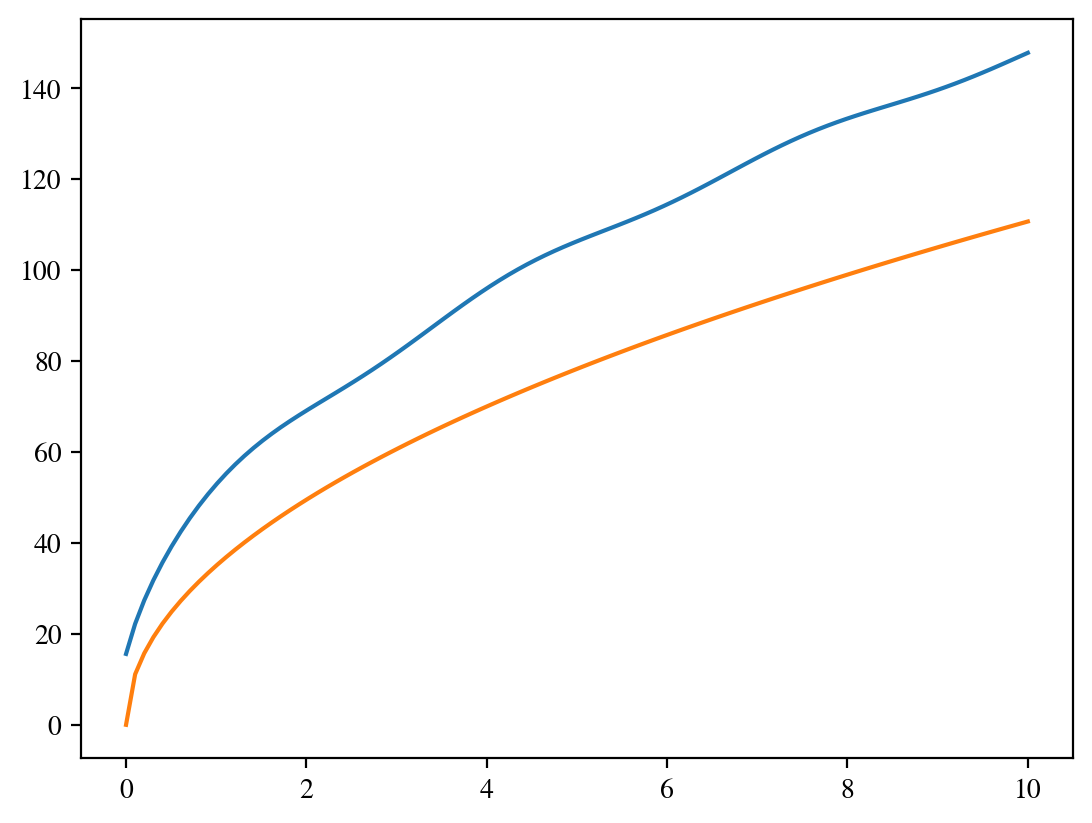

In [17]:
plt.plot(jnp.linspace(0.0, 10.0, 100), snrs, label='SNR');
plt.plot(jnp.linspace(0.0, 10.0, 100), 35.0*jnp.sqrt(jnp.linspace(0.0, 10.0, 100)), label='SNR');

#### BETTER

In [10]:
MAX_NPSRS = 500

@jax.jit
def one_scatter(key, toas, toaerrs, pars):
    # split off a subkey for npsrs
    key, subkey = jax.random.split(key)
    npsrs = jax.random.randint(subkey, (), 10, MAX_NPSRS+1)

    # now always draw MAX_NPSRS directions
    #_, (key_u, key_ra) = jax.random.split(key), jax.random.split(key)
    key, key_u = jax.random.split(key)
    key, key_ra = jax.random.split(key)
    u_all  = jax.random.uniform(key_u,  (MAX_NPSRS,), minval=-1.0, maxval=1.0)
    ra_all = jax.random.uniform(key_ra, (MAX_NPSRS,),  minval=0.0, maxval=2*jnp.pi)
    dec_all = jnp.arcsin(u_all)

    # build mask  [True x npsrs, False elsewhere]
    idx = jnp.arange(MAX_NPSRS)
    mask = idx < npsrs   # shape (MAX_NPSRS,)

    # make unit‐vectors for *all* MAX_NPSRS
    vs = jnp.stack([
      jnp.cos(dec_all)*jnp.cos(ra_all),
      jnp.cos(dec_all)*jnp.sin(ra_all),
      jnp.sin(dec_all)
    ], axis=1)

    # GW source unit vector (same as before)
    gw_dec = jnp.arcsin(pars['cw_costheta'])
    gw_ra  = (pars['cw_phi'] + jnp.pi) % (2*jnp.pi) - jnp.pi
    v0 = jnp.array([
      jnp.cos(gw_dec)*jnp.cos(gw_ra),
      jnp.cos(gw_dec)*jnp.sin(gw_ra),
      jnp.sin(gw_dec),
    ])

    # deep-copy the dictionary so nested objects are also copied
    pars_copy = dict(pars)
    key, subkey2 = jax.random.split(key)
    key, subkey3 = jax.random.split(key)
    key, subkey4 = jax.random.split(key)
    key, subkey5 = jax.random.split(key)
    pars_copy['cw_log10_dist'] = jax.random.uniform(subkey2, minval=2.5, maxval=4.0)
    pars_copy['cw_cosinc'] = jax.random.uniform(subkey3, minval=-0.99, maxval=0.99)
    pars_copy['cw_psi'] = jax.random.uniform(subkey4, minval=0.01, maxval=jnp.pi-0.01)
    pars_copy['cw_phase0'] = jax.random.uniform(subkey5, minval=0.01, maxval=2.0*jnp.pi-0.01)

    # vectorize your per‐pulsar code over size=MAX_NPSRS
    pp_keys = jax.random.split(key, MAX_NPSRS+1)
    def per_pulsar(ra_i, dec_i, inner_key):
        #_, subkey6 = jax.random.split(key)
        toaerrs_tmp = jnp.full_like(toas, 
                                    jax.random.uniform(inner_key, minval=1e-8, maxval=1e-6))
        psr = utils.Pulsar(name="", ra=ra_i, dec=dec_i,
                           toas=toas, toaerrs=toaerrs_tmp)
        cw  = utils.CW_Signal(psr, psr.toas[0], evolve=False)
        snr2 = utils.computer_snr2(cw, pars_copy)
        fish = utils.compute_fisher(cw, pars_copy)[:2,:2]
        return snr2, fish

    all_snr2, all_fish = jax.vmap(per_pulsar)(ra_all, dec_all, pp_keys[1:])
    # mask out the “extra” ones
    all_snr2   = all_snr2   * mask
    all_fish   = all_fish   * mask[:,None,None]

    # now sum only the active ones
    total_f    = jnp.sum(all_fish, axis=0)
    omega      = (180/jnp.pi)**2 * 2*jnp.pi / jnp.linalg.det(total_f)**0.5

    cos_sep    = vs @ v0
    ang_sep    = jnp.degrees(jnp.arccos(cos_sep))

    return key, omega, all_snr2, ang_sep

In [17]:
# 3) now run N realizations “all at once”
N = int(1e3)
# grab microseconds since the epoch, fold into 32-bit range
seed = int(time.time() * 1e6) % (2**31 - 1)
keys = jax.random.split(jax.random.PRNGKey(seed), N+1)
# drop the first as “seed” and vmap
results = jax.vmap(lambda k: one_scatter(k, toas_new, toaerrs, pars))(keys[1:])
results[1].block_until_ready() # Block until the first result component is ready (implies all are)

omegas, all_snr2, all_angsep = results[1], results[2], results[3]

In [18]:
# calculate the array SNR for all synthetic datasets
snrs = jnp.sum(all_snr2, axis=1)**0.5

In [19]:
# calculate the ansatz relationship to describe localization
new_testrelationship = 1.0/jnp.sum(all_snr2 / all_angsep**2.0, axis=1)

In [20]:
#weight = 4.0 / jnp.sin(all_angsep)**2.0 + jnp.sin(all_angsep)**4.0 / (1.0+jnp.cos(all_angsep))**2.0
#new_testrelationship_maybe = np.array(1.0/jnp.sum(all_snr2 * weight, axis=1))

/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_90109/3785223590.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


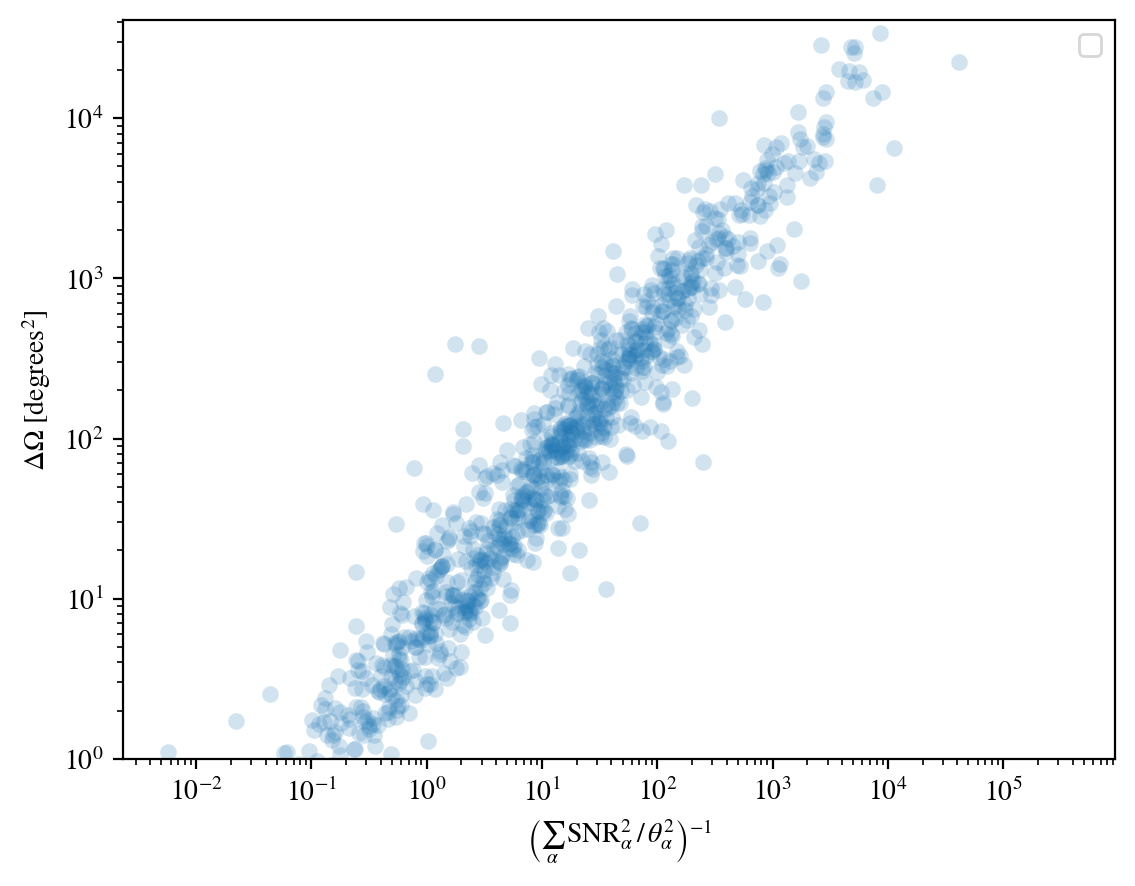

In [29]:
plt.plot(new_testrelationship, omegas, 'o', label='', alpha=0.2, markeredgecolor='none');
#plt.plot(1.0/jnp.sum(all_snr2 / omega_wgtinterp(all_angsep), axis=1), omegas, 'o', label='', alpha=0.2, markeredgecolor='none');
#plt.plot(test_relationship, test_relationship**0.666, 'o', label='');

#plt.plot(new_testrelationship, new_testrelationship, label='$y=x$');
#plt.plot(1.0/jnp.sum(all_snr2 / omega_wgtinterp(all_angsep), axis=1), 1.0/jnp.sum(all_snr2 / omega_wgtinterp(all_angsep), axis=1))

plt.ylim(1.0,41252.96125)
#plt.xlim(0.1,1e5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\left(\\sum_\\alpha\, \mathrm{SNR}_\\alpha^2 \,/\, \\theta_\\alpha^2\\right)^{-1}$')
plt.ylabel('$\Delta\Omega$ [degrees$^2$]')
plt.legend()
plt.show()

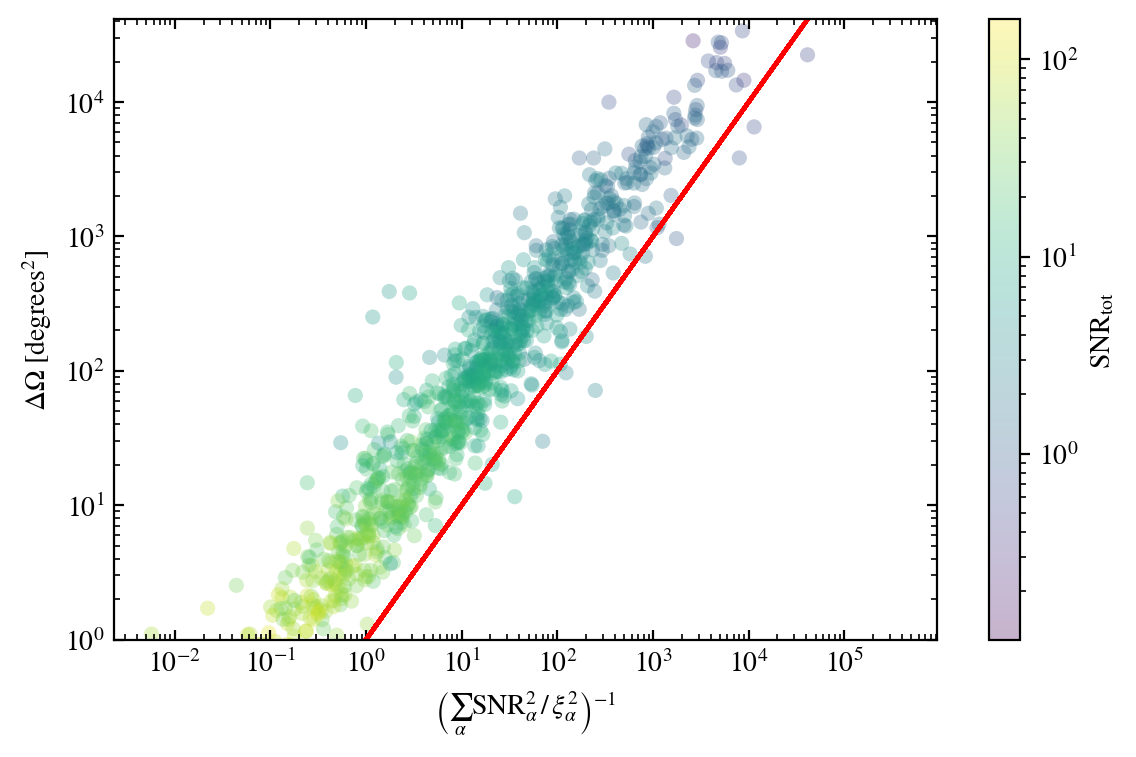

In [45]:
import matplotlib.colors as mcolors

plt.figure(figsize=(6,4))
sc = plt.scatter(
    new_testrelationship, omegas,
    c=snrs,
    #c=jnp.log10(snrs),
    #cmap='Pastel1',
    cmap='viridis',
    norm=mcolors.LogNorm(vmin=snrs.min(), vmax=snrs.max()),  
    s=30,
    alpha=0.3,
    edgecolors='none'
)
plt.plot(new_testrelationship, new_testrelationship, color='red', linestyle='dashed', label='$y=x$');

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\left(\sum_\alpha \mathrm{SNR}_\alpha^2 \,/\, \xi_\alpha^2\right)^{-1}$')
plt.ylabel(r'$\Delta\Omega\ \mathrm{[degrees^2]}$')
plt.ylim(1.0,41252.96125)
#plt.xlim(0.1,41252.96125)

cb = plt.colorbar(sc)
cb.set_label('SNR$_\mathrm{tot}$')

plt.tight_layout()
plt.minorticks_on()
plt.tick_params(which='both', tick2On=True, direction='in')
plt.show()

In [24]:
# Load the data from the .npz file
data = np.load('omega_interpolation_data.npz')
loaded_angles = data['angles']
loaded_omega_weights = data['omega_weights']

# Define the interpolant function using the loaded data
def omega_wgtinterp(theta):
    """
    Interpolate sky-localization area ω as a function of pulsar-separation angle θ.
    This function uses the pre-computed, loaded data.
    """
    return jnp.interp(theta, loaded_angles, loaded_omega_weights)

#### Now what happens when we don't assume everything but the sky location is known?

In [21]:
# parameters assumed unknown
#param_unknown = ['cw_costheta', 'cw_phi', 'cw_cosinc', 'cw_log10_Mc', 'cw_log10_fgw', 'cw_log10_dist', 'cw_phase0', 'cw_psi']
param_unknown = ['cw_costheta', 'cw_phi', 'cw_cosinc', 'cw_log10_Mc', 'cw_log10_fgw', 'cw_log10_dist', 'cw_phase0', 'cw_psi']
inds_unknown = [list(pars.keys()).index(p) for p in param_unknown]
inds_unknown

[0, 1, 2, 3, 4, 5, 6, 7]

In [60]:
MAX_NPSRS = 500

@jax.jit
def one_scatter(key, toas, toaerrs, pars):
    # split off a subkey for npsrs
    _, subkey = jax.random.split(key)
    npsrs = jax.random.randint(subkey, (), 10, MAX_NPSRS+1)

    # now always draw MAX_NPSRS directions
    _, (key_u, key_ra) = jax.random.split(key), jax.random.split(key)
    u_all  = jax.random.uniform(key_u,  (MAX_NPSRS,), minval=-1.0, maxval=1.0)
    ra_all = jax.random.uniform(key_ra, (MAX_NPSRS,),  minval=0.0, maxval=2*jnp.pi)
    dec_all = jnp.arcsin(u_all)

    # build mask  [True x npsrs, False elsewhere]
    idx = jnp.arange(MAX_NPSRS)
    mask = idx < npsrs   # shape (MAX_NPSRS,)

    # make unit‐vectors for *all* MAX_NPSRS
    vs = jnp.stack([
      jnp.cos(dec_all)*jnp.cos(ra_all),
      jnp.cos(dec_all)*jnp.sin(ra_all),
      jnp.sin(dec_all)
    ], axis=1)

    # GW source unit vector (same as before)
    gw_dec = jnp.arcsin(pars['cw_costheta'])
    gw_ra  = (pars['cw_phi'] + jnp.pi) % (2*jnp.pi) - jnp.pi
    v0 = jnp.array([
      jnp.cos(gw_dec)*jnp.cos(gw_ra),
      jnp.cos(gw_dec)*jnp.sin(gw_ra),
      jnp.sin(gw_dec),
    ])

    # deep-copy the dictionary so nested objects are also copied
    pars_copy = copy.deepcopy(pars)
    _, subkey2 = jax.random.split(key)
    _, subkey3 = jax.random.split(key)
    _, subkey4 = jax.random.split(key)
    _, subkey5 = jax.random.split(key)
    pars_copy['cw_log10_dist'] = jax.random.uniform(subkey2, minval=2.5, maxval=4.0)
    pars_copy['cw_cosinc'] = jax.random.uniform(subkey3, minval=-0.99, maxval=0.99)
    pars_copy['cw_psi'] = jax.random.uniform(subkey4, minval=0.01, maxval=jnp.pi-0.01)
    pars_copy['cw_phase0'] = jax.random.uniform(subkey5, minval=0.01, maxval=2.0*jnp.pi-0.01)

    # vectorize your per‐pulsar code over size=MAX_NPSRS
    def per_pulsar(ra_i, dec_i):
        _, subkey6 = jax.random.split(key)
        toaerrs_tmp = jnp.full_like(toas_new, 
                                    jax.random.uniform(subkey6, minval=1e-8, maxval=1e-6))
        psr = utils.Pulsar(name="", ra=ra_i, dec=dec_i,
                           toas=toas, toaerrs=toaerrs_tmp)
        cw  = utils.CW_Signal(psr, psr.toas[0], evolve=False)
        snr2 = computer_snr2(cw, pars_copy)
        fish = compute_fisher(cw, pars_copy) #[:2,:2]
        return snr2, fish

    all_snr2, all_fish = jax.vmap(per_pulsar)(ra_all, dec_all)
    # mask out the “extra” ones
    all_snr2   = all_snr2   * mask
    all_fish   = all_fish   * mask[:,None,None]

    # now sum only the active ones
    total_f    = jnp.sum(all_fish, axis=0)
    inv2       = jnp.linalg.pinv(total_f[inds_unknown, :][: ,inds_unknown])[:2, :2]
    omega      = (180/jnp.pi)**2 * 2*jnp.pi * jnp.linalg.det(inv2)**0.5

    cos_sep    = vs @ v0
    ang_sep    = jnp.degrees(jnp.arccos(cos_sep))

    return key, omega, all_snr2, ang_sep

In [61]:
# 3) now run N realizations “all at once”
N = int(1e3)
# grab microseconds since the epoch, fold into 32-bit range
seed = int(time.time() * 1e6) % (2**31 - 1)
keys = jax.random.split(jax.random.PRNGKey(seed), N+1)
# drop the first as “seed” and vmap
results = jax.vmap(lambda k: one_scatter(k, toas_new, toaerrs, pars))(keys[1:])

omegas, all_snr2, all_angsep = results[1], results[2], results[3]

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:47: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)


In [62]:
# calculate the array SNR for all synthetic datasets
snrs = jnp.sum(all_snr2, axis=1)**0.5

In [63]:
# calculate the ansatz relationship to describe localization
new_testrelationship = np.array(1.0/jnp.sum(all_snr2 / all_angsep**2.0, axis=1))

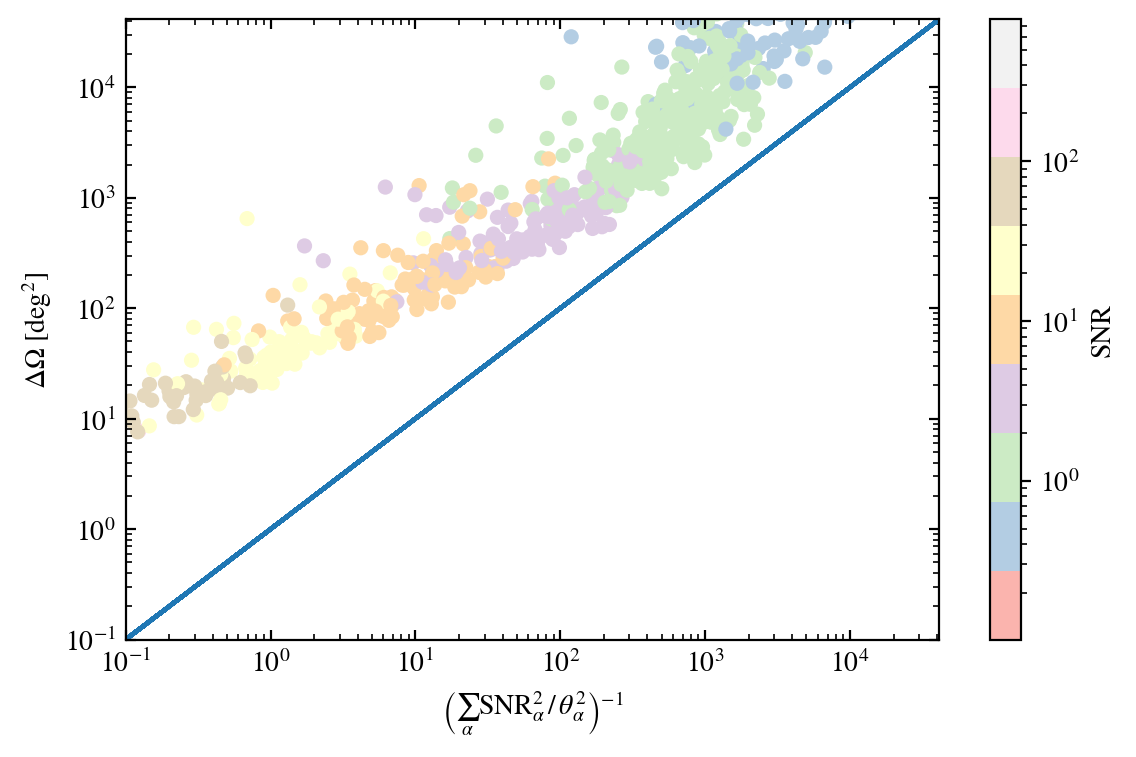

In [67]:
import matplotlib.colors as mcolors

plt.figure(figsize=(6,4))
sc = plt.scatter(
    new_testrelationship, omegas,
    c=snrs,
    cmap='Pastel1',
    norm=mcolors.LogNorm(vmin=snrs.min(), vmax=snrs.max()),  
    s=30,
    alpha=1.,
    edgecolors='none'
)
plt.plot(new_testrelationship, new_testrelationship, label='$y=x$');

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\left(\sum_\alpha \mathrm{SNR}_\alpha^2 \,/\, \theta_\alpha^2\right)^{-1}$')
plt.ylabel(r'$\Delta\Omega\ \mathrm{[deg^2]}$')
plt.ylim(0.1,41252.96125)
plt.xlim(0.1,41252.96125)

cb = plt.colorbar(sc)
cb.set_label('SNR')

plt.tight_layout()
plt.minorticks_on()
plt.tick_params(which='both', tick2On=True, direction='in')
plt.show()

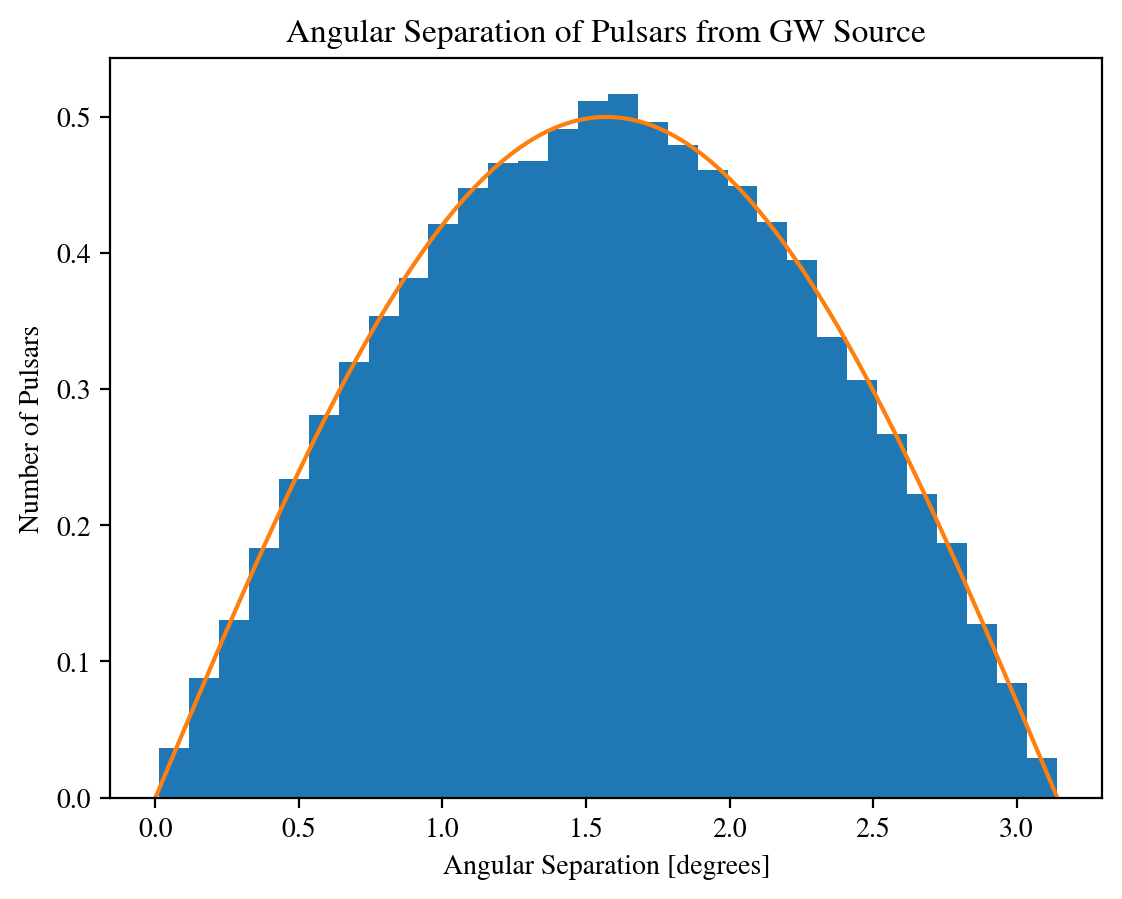

In [35]:
plt.hist(jnp.ravel(jnp.radians(all_angsep)), bins=30, histtype='stepfilled', density=True)
plt.plot(jnp.linspace(0, jnp.pi, 100),
         jnp.sin(jnp.linspace(0, jnp.pi, 100))*0.5,
         color='C1', label='Uniform Distribution')
plt.xlabel('Angular Separation [degrees]')
plt.ylabel('Number of Pulsars')
plt.title('Angular Separation of Pulsars from GW Source');
plt.show()